In [1]:
import tensorflow as tf
import numpy as np
import sys

from sklearn.metrics import mean_squared_error
from keras.callbacks import LearningRateScheduler

from tensorflow.python import debug as tf_debug
#from sklearn.preprocessing import MinMaxScaler ##########

#sys.path.append('/Users/davidlaredorazo/Documents/University_of_California/Research/Projects')
#sys.path.append('/media/controlslab/DATA/Projects')
sys.path.append('/Users/Think/Desktop/project')

#Tunable model
from ann_framework.tunable_model.tunable_model import SequenceTunableModelRegression

#Data handlers
from ann_framework.data_handlers.data_handler_Grid import GridDataHandler

#Custom modules
from ann_framework import aux_functions

import aux_functions_stochastic
import analytic_functions
import loss_functions

import matplotlib.pyplot as plt


D:\Anaconda3\Anaconda3_Python6\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#declare specifics of the ODE
deltas = [10**(-5)]
variable_boundaries = [[0, 1]]
points_per_dimension = [1000]

#Boundary conditions
initial_xs = np.array([[0]])
initial_ys = np.array([[1]])

num_features = len(points_per_dimension)
num_conditions = len(initial_xs)
num_output = 1

#two d-dimensional points for each dimension to compute the derivatives plus the original point
num_fevals = len(points_per_dimension)*2+1 

### Define tensorflow model

In [3]:
def create_placeholders(input_shape, output_shape):
    
    X = tf.placeholder(tf.float32, shape=(None,input_shape), name="X")
    y = tf.placeholder(tf.float32, shape=None, name="y")
    
    return X, y

def tf_simple_ode(X):
    
    #l2_lambda_regularization = 0.1
    #l1_lambda_regularization = 0.10
    
    A1 = tf.layers.dense(X, 50, activation=tf.nn.relu, 
                         kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False), 
                         name="fc1")
    y = tf.layers.dense(A1, 1, activation=None, kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False),
                        name="out")
    
    return y


### Create Model TF

In [4]:
def tf_compiled_model(num_features, output_shape, num_fevals=1, num_conditions=0, alpha=1):
    tf.reset_default_graph()

    X, y = create_placeholders(num_features, output_shape)
    y_pred = tf_simple_ode(X)
    
    loss_function =  loss_functions.residual_function_wrapper(num_features, output_shape, 
                                                                     deltas, num_fevals, num_conditions, alpha)
    cost, e = loss_function(X, y_pred, y)
    #reg_cost = tf.losses.get_regularization_loss()
    total_cost = cost
    
    optimizer = tf.train.AdamOptimizer(learning_rate=0.05, beta1=0.8).minimize(total_cost)

    return {'X_placeholder': X, 'y_placeholder': y, 'y_pred': y_pred, 'cost': cost, 'total_cost': total_cost, 'optimizer': optimizer}

## Create Tunable Model Tensorflow and assign data

### For simple ODE

In [5]:
#scaler = MinMaxScaler()

dhandler_grid = GridDataHandler()

model = tf_compiled_model(num_features=num_features, output_shape=num_output, num_fevals=num_fevals, 
                          num_conditions=num_conditions, alpha=1)

tModel = SequenceTunableModelRegression('ModelStochastic_SN_1', model, lib_type='tensorflow', 
                                        data_handler=dhandler_grid, batch_size=256)

tModel.load_data(verbose=1, cross_validation_ratio=0.2, boundaries=variable_boundaries, n=points_per_dimension)

#Real function
tModel.y_test = analytic_functions.eg1(tModel.X_test[:,0])
tModel.y_train = analytic_functions.eg1(tModel.X_train[:,0])
tModel.y_crossVal = analytic_functions.eg1(tModel.X_crossVal[:,0])

tModel.print_data()

Instructions for updating:
Use tf.print instead of tf.Print. Note that tf.print returns a no-output operator that directly prints the output. Outside of defuns or eager mode, this operator will not be executed unless it is directly specified in session.run or used as a control dependency for other operators. This is only a concern in graph mode. Below is an example of how to ensure tf.print executes in graph mode:
```python
    sess = tf.Session()
    with sess.as_default():
        tensor = tf.range(10)
        print_op = tf.print(tensor)
        with tf.control_dependencies([print_op]):
          out = tf.add(tensor, tensor)
        sess.run(out)
    ```
Additionally, to use tf.print in python 2.7, users must make sure to import
the following:

  `from __future__ import print_function`

Loading data for the first time
Reloading data due to parameter change
Loading data. Cros-Validation ratio 0.2
Printing shapes

Training data (X, y)
(720, 1)
(720, 1)
Cross-Validation data (X, y)
(180

D:\Anaconda3\Anaconda3_Python6\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


### Train model Tensorflow

In [6]:
tModel.epochs = 100
minibatches_function_handle = aux_functions_stochastic.get_minibatches

sess = tf.Session()

tModel.train_model(tf_session=sess, get_minibatches_function_handle=minibatches_function_handle, 
                   verbose=1, deltas=deltas, initial_xs=initial_xs, initial_ys=initial_ys)

    # cost_reg: total_cost -> e
    # cost: R

Epoch: 0001 cost_reg= 1.963740011 cost= 1.963740011
Epoch: 0002 cost_reg= 0.588403980 cost= 0.588403980
Epoch: 0003 cost_reg= 0.158846200 cost= 0.158846200
Epoch: 0004 cost_reg= 0.208976403 cost= 0.208976403
Epoch: 0005 cost_reg= 0.096501296 cost= 0.096501296
Epoch: 0006 cost_reg= 0.116043975 cost= 0.116043975
Epoch: 0007 cost_reg= 0.066569716 cost= 0.066569716
Epoch: 0008 cost_reg= 0.084508543 cost= 0.084508543
Epoch: 0009 cost_reg= 0.076769426 cost= 0.076769426
Epoch: 0010 cost_reg= 0.078072359 cost= 0.078072359
Epoch: 0011 cost_reg= 0.078784208 cost= 0.078784208
Epoch: 0012 cost_reg= 0.075626952 cost= 0.075626952
Epoch: 0013 cost_reg= 0.070823371 cost= 0.070823371
Epoch: 0014 cost_reg= 0.067936835 cost= 0.067936835
Epoch: 0015 cost_reg= 0.065237141 cost= 0.065237141
Epoch: 0016 cost_reg= 0.060585387 cost= 0.060585387
Epoch: 0017 cost_reg= 0.059210174 cost= 0.059210174
Epoch: 0018 cost_reg= 0.060260452 cost= 0.060260452
Epoch: 0019 cost_reg= 0.067916642 cost= 0.067916642
Epoch: 0020 

In [7]:
display_points = 20

tModel.evaluate_model(['mse', 'rmse'], cross_validation=True, tf_session=sess)
X_test = tModel.X_crossVal
y_pred = tModel.y_predicted
y_real = tModel.y_crossVal
print("scores")

print(X_test)
print(y_real)

cScores = tModel.scores
#rmse = math.sqrt(cScores['score_1'])
rmse2 = cScores['rmse']
mse = cScores['mse']
time = tModel.train_time

total_points = len(y_pred)
sample_array = list(range(total_points))

sample_points = np.random.choice(sample_array, display_points)
print(sample_points)

y_real_sampled = y_real[sample_points]
y_pred_sampled = y_pred[sample_points]
X_sampled = X_test[sample_points,:]

print(y_real_sampled)

i = range(len(y_pred_sampled))


for x, y_real_display, y_pred_display in zip(X_sampled, y_real_sampled, y_pred_sampled):
    print('x {}, Real y {}, Predicted y {}'.format(x, y_real_display, y_pred_display))

#print("RMSE: {}".format(rmse))
print("RMSE2: {}".format(rmse2))
print("MSE: {}".format(mse))
print("Time : {} seconds".format(time))

scores
[[0.67067067]
 [0.24424424]
 [0.72972973]
 [0.24924925]
 [0.78178178]
 [0.45145145]
 [0.1961962 ]
 [0.53353353]
 [1.        ]
 [0.09309309]
 [0.68368368]
 [0.22722723]
 [0.18218218]
 [0.4984985 ]
 [0.04304304]
 [0.47247247]
 [0.81981982]
 [0.00500501]
 [0.70570571]
 [0.80980981]
 [0.36236236]
 [0.8978979 ]
 [0.82182182]
 [0.67267267]
 [0.84984985]
 [0.41841842]
 [0.35635636]
 [0.34934935]
 [0.38538539]
 [0.85385385]
 [0.30530531]
 [0.22022022]
 [0.60960961]
 [0.17117117]
 [0.05705706]
 [0.33433433]
 [0.59159159]
 [0.84484484]
 [0.48648649]
 [0.71971972]
 [0.67667668]
 [0.17217217]
 [0.76276276]
 [0.94894895]
 [0.27527528]
 [0.17817818]
 [0.25425425]
 [0.85985986]
 [0.36636637]
 [0.03703704]
 [0.20820821]
 [0.29329329]
 [0.17417417]
 [0.2982983 ]
 [0.06606607]
 [0.96196196]
 [0.33233233]
 [0.83583584]
 [0.3963964 ]
 [0.37237237]
 [0.01901902]
 [0.92292292]
 [0.58058058]
 [0.43743744]
 [0.98498498]
 [0.48148148]
 [0.77777778]
 [0.19219219]
 [0.04804805]
 [0.25525526]
 [0.63863864]

In [8]:
x = np.linspace(0, 1, 100000)
y = analytic_functions.eg1(x)

# # real NN

# # # y = e^(-x) + 1
# # A = 2
# # nn_real = (np.exp(-x) + 1 - A)/ x

# # y = #1
# A = 1
# nn_real = ((np.exp(- np.power(x, 2)/2))/(1 + x + np.power(x, 3)) + np.power(x, 2)- A)/x

# # # y = #2
# # A = 0
# # nn_real = (np.exp(-x/5) * np.sin(x)- A)/x

# # y_pred by pred NN
# m_nn = np.multiply(X_test, y_pred)
# y_nn = A + m_nn
# print(y_nn)

In [9]:
# plt.scatter(X_test.flatten(), y_nn,c='r')  #y_pred
# plt.scatter(X_test.flatten(),y_real.flatten(),c='b')  #y_real

# plt.show()

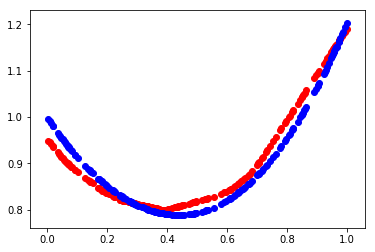

In [11]:
plt.scatter(X_test.flatten(), y_pred.flatten(),c='r')  # y_pred/nn_pred
plt.scatter(X_test.flatten(),y_real.flatten(),c='b')  # y_real
# plt.scatter(x,nn_real,c='b')  #nn_real

# plt.show()